![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [12]:
# Celda 1.1
print(bikes.groupby('season')['total'].describe())
bikes.groupby('season').total.mean()

         count        mean         std  min   25%    50%    75%    max
season                                                                
1       2686.0  116.343261  125.273974  1.0  24.0   78.0  164.0  801.0
2       2733.0  215.251372  192.007843  1.0  49.0  172.0  321.0  873.0
3       2733.0  234.417124  197.151001  1.0  68.0  195.0  347.0  977.0
4       2734.0  198.988296  177.622409  1.0  51.0  161.0  294.0  948.0


season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Revisando los datos se puede ver que para cada estacion presenta unos datos relevantes:

#### Invierno

    -La cantidad promedio de alquileres de bicicletas es de aproximadamente 116.
    -El mínimo de alquileres en una hora es 1, y el máximo es 801.
    -El 25% de los alquileres están por debajo de 24, el 50% están por debajo de 78 y el 75% están por debajo de 164.

#### Primavera

    -La cantidad promedio de alquileres de bicicletas es de aproximadamente 215.
    -El mínimo de alquileres en una hora es 1, y el máximo es 873.
    -El 25% de los alquileres están por debajo de 49, el 50% están por debajo de 172 y el 75% están por debajo de 321.

#### Verano

    -La cantidad promedio de alquileres de bicicletas es de aproximadamente 234.
    -El mínimo de alquileres en una hora es 1, y el máximo es 977.
    -El 25% de los alquileres están por debajo de 68, el 50% están por debajo de 195 y el 75% están por debajo de 347.

#### Otoño

    -La cantidad promedio de alquileres de bicicletas es de aproximadamente 199.
    -El mínimo de alquileres en una hora es 1, y el máximo es 948.
    -El 25% de los alquileres están por debajo de 51, el 50% están por debajo de 161 y el 75% están por debajo de 294.

Segun los datos expuestos podemos concluir que desde la temporada de Invierno hasta la de Verano tiene un crecimiento gradual en el alquiler de bicicletas en el cual Verano es donde mas se alquinan y en Otoño comienza a tener una tendencia decreciente de alquiler de bicicletas.

In [13]:
# Celda 1.2
print(bikes.groupby('hour')['total'].describe())
bikes.groupby('hour').total.mean()

      count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     442.0    6.407240    4.217633   1.0    3.00    6.0    9.00   28.0
5     452.0   19.767699   12.784293   1.0    8.00   19.0   29.00   57.0
6     455.0   76.259341   54.745333   1.0   24.50   75.0  118.00  213.0
7     455.0  213.116484  159.207044   1.0   63.00  208.0  334.00  596.0
8     455.0  362.769231  231.723065   8.0  133.50  392.0  563.50  839.0
9     455.0  221.780220   92.099209  14.0  161.00  217.0  294.50  414.0
10    455.0  175.092308  101.807629  17.0  106.00  149.0  218.50  539.0
11    455.0  210.674725  127.444294  10.0  123.00  183.0  265.50

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

Segun los datos que se visualizan y los horarios en los que mas se alquina bicicletas  en horas de la mañana esta entre 7 y 9 am de la mañana y en la tarde son de 3 a 6 pm con máximos que superan los 400 alquileres por hora.

Tambien se puede ver que las horas en que menos se alquilan bicicletas es en horas de la madrugada entre 3 a 5 am y durante la noches va tendiendo un decrecimiento hasta las horas de la mañana.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

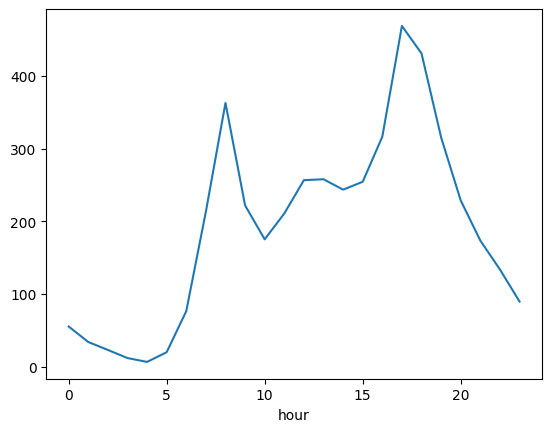

In [14]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

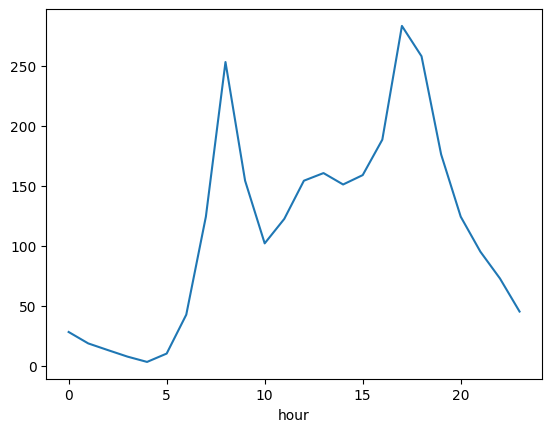

In [28]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()


Segun la grafica en la temporada de invierno se puede observar que desde las 5 am tiene una tendencia creciente hasta las 8 am y luego comienza a decrecer levemente hasta las 10 am luego vuelve a tener un crecimiento a las 5pm hasta llegar a su punto mas alto durante el dia luego comienza a tener un decrecimiento hasta las 4 am, tambien se puede ver que los picos mas altos en horas de la mañana y de la tarde son a las 8am con 253 alquileres en promedio y a las 5pm con 283 alquileres en promedio y se puede ver que el pico mas bajo donde no se alquilan bicicletas es a las  4 am con 3 en promedio, con esta informacion se puede concluir que las horas mas congestionadas son a las 8am y 5pm.

<Axes: xlabel='hour'>

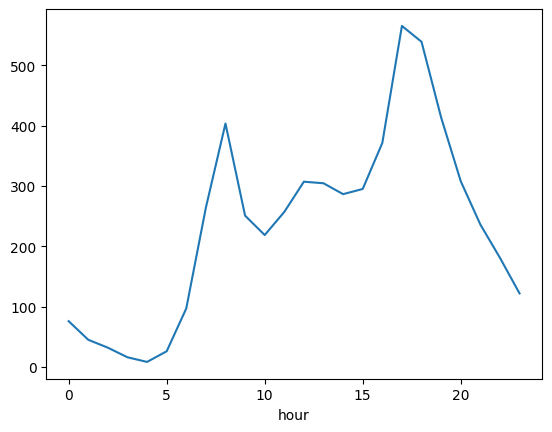

In [26]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()


Segun la grafica en la temporada de verano se puede observar que desde las 5 am tiene una tendencia creciente hasta las 8 am y luego comienza a decrecer levemente hasta las 10 am luego vuelve a tener un crecimiento a las 5pm hasta llegar a su punto mas alto durante el dia luego comienza a tener un decrecimiento hasta las 4 am, tambien se puede ver que los picos mas altos en horas de la mañana y de la tarde son a las 8am con 403 alquileres en promedio y a las 5pm con 565 alquileres en promedio y se puede ver que el pico mas bajo donde no se alquilan bicicletas es a las  4 am con 8 en promedio, con esta informacion se puede concluir que las horas mas congestionadas son a las 8am y 5pm.

Segun las dos graficas se puede notar un comportamiento similar en las tendecias de alquiler de bicicleta tanto en invierno como en verano, la diferencia en verano se alquilan mas bicicletas que en invierno en su totalidad y esto genera que en los picos se vea mayor cantidad en el alquiler de estas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [52]:
# Celda 3
X = bikes[['season', 'hour']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(categories=[[1, 2, 3, 4]]), ['season'])
    ],
    remainder='passthrough'
)

model = Pipeline(steps=[('preprocessor', transformer),
                        ('regressor', LinearRegression())])

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)

y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Error cuadrático medio (MSE) en conjunto de entrenamiento:", mse_train)
print("Error cuadrático medio (MSE) en conjunto de prueba:", mse_test)

Error cuadrático medio (MSE) en conjunto de entrenamiento: 25503.908774393876
Error cuadrático medio (MSE) en conjunto de prueba: 25397.728464958534


Los resultados sugieren que la regresión lineal podría no ser la opción más adecuada para este conjunto de datos, dado que podría haber multicolinealidad, sobreajuste y otras limitaciones. Por consiguiente, sería prudente realizar una validación utilizando árboles de decisión para determinar si este modelo ofrece una interpretación más precisa de los resultados.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [89]:
# Celda 4

X = bikes[['hour', 'season']]
y = bikes['total']

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Función para calcular la impureza de Gini
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def best_split(X, y):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]
    
    for j in features:
        for split in X.iloc[:, j].unique():
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, min_samples_leaf=6, max_depth=None):#control de los 6 nodos
    
    if X.shape[0] == 1 or level == max_depth or X.shape[0] < min_samples_leaf:
        tree = dict(y_pred=y.mean(), level=level, split=-1, n_samples=X.shape[0], gain=0)
        return tree
    
    j, split, gain = best_split(X, y)
    
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    if gain < min_gain:
        return tree
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
    
    return tree

def print_tree(tree, depth=0):
    if tree['split'] == -1:
        print(depth * '  ' + 'Predicción:', tree['y_pred'])
        return
    print(depth * '  ' + 'Variable:', X.columns[tree['split'][0]], 'Split:', tree['split'][1])
    print(depth * '  ' + 'Ganancia de información:', tree['gain'])
    print_tree(tree['sl'], depth + 1)
    print_tree(tree['sr'], depth + 1)

tree = tree_grow(X, y, level=0, min_gain=0.001, min_samples_leaf=6, max_depth=6)
print_tree(tree)


Variable: hour Split: 7
Ganancia de información: 20485.13561876939
  Variable: hour Split: 6
  Ganancia de información: 646.8008927589567
    Variable: hour Split: 2
    Ganancia de información: 382.8088308604629
      Variable: season Split: 2
      Ganancia de información: 291.4004681825131
        Variable: hour Split: 1
        Ganancia de información: 45.41972746495435
          Predicción: 28.292035398230087
          Predicción: 18.761061946902654
        Variable: hour Split: 1
        Ganancia de información: 316.1751143186211
          Variable: season Split: 4
          Ganancia de información: 37.59626038780971
            Predicción: 67.07456140350877
            Predicción: 57.87719298245614
          Variable: season Split: 3
          Ganancia de información: 10.425846423569055
            Predicción: 35.64035087719298
            Predicción: 40.480176211453745
      Variable: hour Split: 3
      Ganancia de información: 39.229899273669275
        Variable: season Split

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [55]:
# Celda 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depth_range = range(1, 24)

tree_reg = DecisionTreeRegressor()

param_grid = {'max_depth': max_depth_range}

grid = GridSearchCV(estimator=tree_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

print("Mejor valor de max_depth:", grid.best_params_)
mse = -grid.best_score_
print("Error cuadrático medio en conjunto de validación:", mse)
y_pred = grid.best_estimator_.predict(X_test)
mse_test_tree = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio en conjunto de prueba:", mse_test_tree)

Mejor valor de max_depth: {'max_depth': 8}
Error cuadrático medio en conjunto de validación: 12905.804423909658
Error cuadrático medio en conjunto de prueba: 13464.749112666655


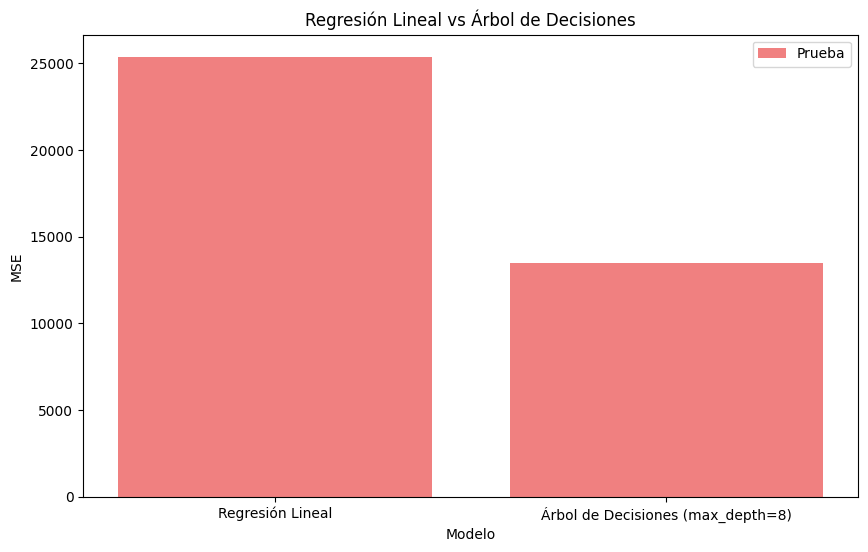

In [58]:
mse_entrenamiento_regresion = mse_train
mse_prueba_regresion = mse_test

mejor_max_depth = grid.best_params_['max_depth']
mejor_arbol = grid.best_estimator_
mse_entrenamiento_arbol = -grid.best_score_
mse_prueba_arbol = mse_test_tree

modelos = ['Regresión Lineal', f'Árbol de Decisiones (max_depth={mejor_max_depth})']
mse_prueba = [mse_prueba_regresion, mse_prueba_arbol]

plt.figure(figsize=(10, 6))
plt.bar(modelos, mse_prueba, color='lightcoral', label='Prueba')

plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.title('Regresión Lineal vs Árbol de Decisiones')
plt.legend()

plt.show()

Se observa que el modelo de árbol de decisiones con una profundidad máxima de 8 tiene un MSE significativamente menor en el conjunto de prueba en comparación con el modelo de regresión lineal. Esto sugiere que el modelo de árbol de decisiones tiene un mejor rendimiento en términos de ajuste y generalización en comparación con el modelo de regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [59]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [60]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [61]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [65]:
# Celda 6
tree_clf = DecisionTreeClassifier(random_state=1)

# Parámetros a calibrar para el árbol de decisiones
param_grid_tree = {
    'max_depth': [None, 5, 10, 15],  # Ajusta la profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Ajusta el número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 5]  # Ajusta el número mínimo de muestras requeridas para estar en un nodo hoja
}

log_reg = LogisticRegression(max_iter=1000)


param_grid_logreg = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}


grid_tree = GridSearchCV(tree_clf, param_grid_tree, cv=5, scoring='accuracy')
grid_tree.fit(X_train, y_train)


grid_logreg = GridSearchCV(log_reg, param_grid_logreg, cv=5, scoring='accuracy')
grid_logreg.fit(X_train, y_train)


best_tree_model = grid_tree.best_estimator_


best_logreg_model = grid_logreg.best_estimator_


y_pred_tree = best_tree_model.predict(X_test)
y_pred_logreg = best_logreg_model.predict(X_test)


accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)


accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("Desempeño del árbol de decisiones:")
print(f"Accuracy: {accuracy_tree}")
print(f"F1-Score: {f1_tree}")
print("\nDesempeño de la regresión logística:")
print(f"Accuracy: {accuracy_logreg}")
print(f"F1-Score: {f1_logreg}")


Desempeño del árbol de decisiones:
Accuracy: 0.6373333333333333
F1-Score: 0.6616915422885573

Desempeño de la regresión logística:
Accuracy: 0.6473333333333333
F1-Score: 0.6379192334017796


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [85]:
# Celda 7

decision_trees_max_depth = []
for _ in range(100):
    tree = DecisionTreeClassifier(max_depth=3)
    bagged_tree = BaggingClassifier(base_estimator=tree, n_estimators=1, random_state=1)
    bagged_tree.fit(X_train, y_train)
    decision_trees_max_depth.append(('tree_max_depth_' + str(_), bagged_tree))

decision_trees_min_samples_leaf = []
for _ in range(100):
    tree = DecisionTreeClassifier(min_samples_leaf=5)
    bagged_tree = BaggingClassifier(base_estimator=tree, n_estimators=1, random_state=1)
    bagged_tree.fit(X_train, y_train)
    decision_trees_min_samples_leaf.append(('tree_min_samples_leaf_' + str(_), bagged_tree))

logistic_regressions = []
for _ in range(100):
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    logistic_regressions.append(('logistic_regression_' + str(_), logistic_regression))



In [86]:

models = decision_trees_max_depth + decision_trees_min_samples_leaf + logistic_regressions
voting_clf = VotingClassifier(estimators=models, voting='hard')

voting_clf.fit(X_train, y_train)

predictions_majority_vote = voting_clf.predict(X_test)

accuracy_majority_vote = accuracy_score(y_test, predictions_majority_vote)
f1_majority_vote = f1_score(y_test, predictions_majority_vote)

print("Accuracy es:",accuracy_majority_vote)
print("F1-Score es:",f1_majority_vote)

Accuracy es: 0.6193333333333333
F1-Score es: 0.5767234988880653


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [87]:
# Celda 8

models = []

for i in range(100):
    tree = DecisionTreeClassifier(max_depth=3)
    bagged_tree = BaggingClassifier(base_estimator=tree, n_estimators=1, random_state=1)
    bagged_tree.fit(X_train, y_train)
    models.append(('tree_max_depth_' + str(i), bagged_tree))


for i in range(100):
    tree = DecisionTreeClassifier(min_samples_leaf=5)
    bagged_tree = BaggingClassifier(base_estimator=tree, n_estimators=1, random_state=1)
    bagged_tree.fit(X_train, y_train)
    models.append(('tree_min_samples_leaf_' + str(i), bagged_tree))


for i in range(100):
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    models.append(('logistic_regression_' + str(i), logistic_regression))



In [88]:
voting_clf_weighted = VotingClassifier(estimators=models, voting='soft')


voting_clf_weighted.fit(X_train, y_train)


predictions_weighted_vote = voting_clf_weighted.predict(X_test)


accuracy_weighted_vote = accuracy_score(y_test, predictions_weighted_vote)
f1_weighted_vote = f1_score(y_test, predictions_weighted_vote)

print("Accuracy es:",accuracy_weighted_vote)
print("F1-Score es:",f1_weighted_vote)

Accuracy es: 0.6013333333333334
F1-Score es: 0.5975773889636609


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

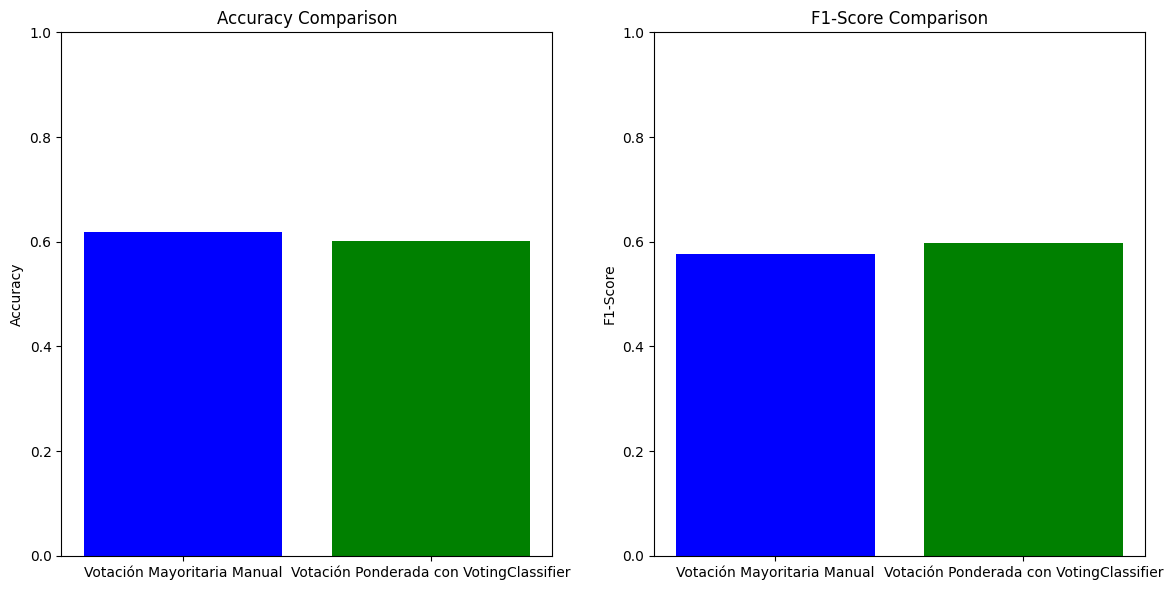

In [81]:
# Celda 9
accuracy_scores = [accuracy_majority_vote, accuracy_weighted_vote]
f1_scores = [f1_majority_vote, f1_weighted_vote]
labels = ['Votación Mayoritaria Manual', 'Votación Ponderada con VotingClassifier']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(labels, accuracy_scores, color=['blue', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(labels, f1_scores, color=['blue', 'green'])
plt.title('F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Segun la popularidad de las noticias online si es o no popular utilizando métricas como Accuracy y F1-Score segun los resultados obtenidos en el punto 7 en el cual se utilizo la metodología de votación mayoritaria para combinar 300 modelos de árboles de decisión y regresiones logísticas. El modelo resultante logró un Accuracy de 0.6193333333333333 y un F1-Score de 0.5767234988880653 mientras que en el punto 8 se empleó la metodología de votación ponderada para combinar los mismos 300 modelos en el cual se tubo un Accuracy de 0.6013333333333334 y un F1-Score de 0.5975773889636609.

viendo los resultados resultados se puede observar rendimientos similares para predecir la popularidad de las noticias, pero se puede ver que la votacion ponderada tiene un mejor F1-Score con un Accuracy mas bajo a en comparacion con la votacion mayoritaria.La votación mayoritaria ofrece una implementación sencilla, pero no considera la confianza de los modelos en sus predicciones. Por otro lado, la votación ponderada tiene la ventaja de considerar la confianza de los modelos, aunque puede requerir una mayor especificidad en los pesos asignados a cada modelo, tambien se podria utilizar en los modelos una regularizacion como Lasso o Ridge y asi evitar el sobreajuste de los modelos.